#Project In Progress
___

# Some installations

In [1]:
!pip -q install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00


In [2]:
!pip -q install ale-py

In [3]:
!pip -q install "gymnasium[atari,accept-rom-license,other]" ale-py

In [65]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
from tensorboardX import SummaryWriter
import random
from collections import namedtuple,deque




# Let's Start The Project

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [48]:
gym.register_envs(ale_py)

In [51]:
env=gym.make("ALE/SpaceInvaders-v5")

In [52]:
image_of_game=env.reset(seed=41)

In [53]:
frame_dim=image_of_game[0].shape
print(f'The Frame Dimensions Are:{frame_dim}')

The Frame Dimensions Are:(210, 160, 3)


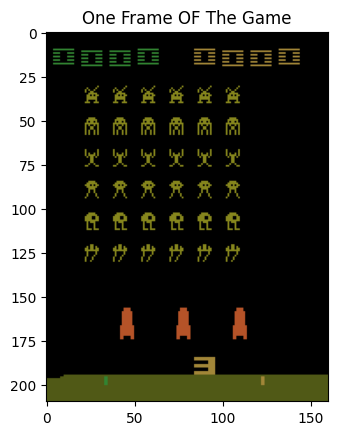

In [54]:
plt.title('One Frame OF The Game')
plt.imshow(image_of_game[0])

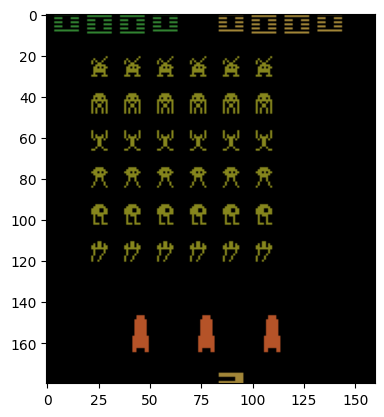

In [55]:
plt.imshow(image_of_game[0][10:190])

In [56]:
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 6



* 0=> NOOP,
* 1=> FIRE,
* 2=> RIGHT,
* 3=> LEFT,
* 4=> RIGHTFIRE,
* 5=> LEFTFIRE

In [57]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [58]:
new_image=env.step(1)

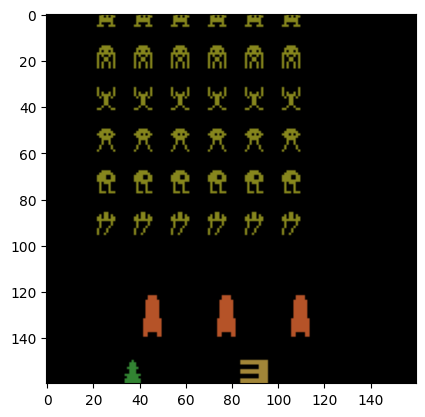

In [ ]:
plt.imshow(new_image[0][35:195])


# Make Frames 80x80 float array

In [61]:
def prepro(I):
    """Preprocess 210x160x3 uint8 frame into 80x80 float array"""
    I = I[35:195]  # crop
    #I = I[::3, ::3, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float32)

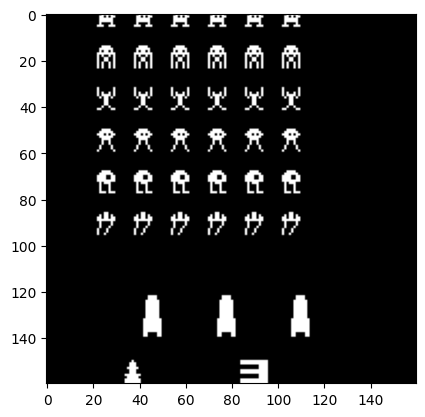

In [63]:
prepro_frame=prepro(new_image[0])
plt.imshow(prepro_frame)
#This is what my model will see

___
# My 1st DQN
___

In [64]:
class DQNet(nn.Module):
    def __init__(self,input_shape,n_actions):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)


        self.head = nn.Linear(1568, 6)  # could be 6 but is more challenging

        # Store episode data
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        # Return logits
        return self.head(x)

# ReplayBuffer
___

In [66]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):


        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed=random.seed(seed)

    def add_exp(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state,done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

___
# The Agent
___

In [67]:
LEARNING_RATE=(5e-4)/2
BUFFER_SIZE=int(1e5)
BATCH_SIZE=32
GAMMA=0.9
TAU=1e-3

In [68]:
class Agent():
  def __init__(self,env,exp_buffer,seed):

    self.seed=random.seed(seed)
    self.qnet_local=DQNet(state_size,action_size,seed).to(device)
    self.qnet_target=DQNet(state_size,action_size,seed).to(device)
    self.optimizer=torch.optim.NAdam(self.qnet_local.parameters(),lr=LEARNING_RATE)
    self.memory=ReplayBuffer(action_size,BUFFER_SIZE,BATCH_SIZE,seed)
    self.t_step=0

  def step(self,state,action,reward,next_state,done):
    self.memory.add_exp(state,action,reward,next_state,done)
    self.t_step=(self.t_step+1)%4
    if self.t_step==0:
      if len(self.memory)>BATCH_SIZE:
        experiences=self.memory.sample()
        self.learn(experiences,GAMMA)

  def act(self,state,eps=0):
    state=torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnet_local.eval()
    with torch.no_grad():
      action_values=self.qnet_local(state)
    self.qnet_local.train()

    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

  def learn(self,experiences,gamma):
    states,actions,rewards,next_states,dones=experiences
    self.optimizer.zero_grad()
        # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1) # detach it from the computation graph
        # Compute Q targets for current states
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
    Q_expected = self.qnetwork_local(states).gather(1, actions) # gather the values along an 1 axis

        # Compute loss
    loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
    loss.backward()
    self.optimizer.step()

        # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

  def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [ ]:
agent=Agent(state_size=8,action_size=6)